# Linear Models II,  GLM

**Prerequisites**

- Linear Algebra
- Calculus
- Some probability/statistics
- Linear Models 1


**Outcomes**

- Understand the generalized linear model (GLM)
- Apply GLM to binary, count, and severity targets

In [1]:
#%pip install --user pyarrow python-snappy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
import seaborn as sns
import scipy.stats as st

from IPython.display import set_matplotlib_formats
plt.style.use("seaborn")
%matplotlib inline
set_matplotlib_formats('svg')

## Generalized Linear Models (GLMs)

Extension of the linear regression model to additional settings, such as:

-   Binary data (logistic regression)
-   Count data (Poisson regression)
-   Variance of predictor should vary with mean of predictor
    (Gamma regression)

### Standard Linear Regression

-   The standard linear regression model can be written $$y_i = x_i^T
           \theta + \epsilon_i$$
-   The standard assumption is that $\epsilon_i \stackrel{\text{iid}}{\sim}
           N(0, \sigma^2)$
-   Under this assumption, three are three key features of the model:
    1.  The mean of predictions $\mu_i = E[y_i | x_i]$ depends on the linear
        predictor $\eta_i {\color{blue} \triangleq} x_i^T \theta$
    2.  The distribution of predictions is $y_i | x_y \sim N(\mu_i, \sigma^2)$
    3.  The expected response is equal to linear predictor $\mu_i = \eta_i$

### GLM: Links and Families

-   The **generalized linear model** loosens restrictions 2 and 3
-   The distribution of predictions $y_i | x_i$ can come from the family of
    exponential dispersion models: $$y_i | x_i \sim f_{EDM}(y_i | x_i, \beta, \phi)
           = \exp \left(\frac{y \beta -  b(\beta)}{\phi} + c(y; \phi) \right)$$
    -   $\beta$ is called the **canonical parameter** and depends on the linear
        predictor $\eta$ # --> changes with x
    -   $\phi$ is called the **dispersion parameter** --> doesnt change with x
-   Relaxing assumption 3, we also relate the expected response to the linear
    prediction via a function $g$ called the **link function**: $$g(\mu_i) = \eta_i$$

### GLM: 3 key assumptions

-   Restating assumptions 1-3 for the GLM, we have
    1.  The mean of predictions $\mu_i = E[y_i | x_i]$ depends on the linear
        predictor $\eta_i \triangleq x_i^T \theta$
    2.  The distribution of predictions is $y_i | x_i \sim f_{EDM}(y_i |x_i, \beta,
                  \phi)$
    3.  The expected response related to the linear predictor my a monotonic
        link function $g$: $g(\mu_i) = \eta_i$

### Example: Linear Regression Model

-   Recall the pdf of the Normal distribution: $$f(y; \mu, \sigma) =
           \frac{1}{\sigma \sqrt{2 \pi}} \exp \left(\frac{(y - \mu)^2}{2 \sigma^2} \right)$$
-   The standard linear regression model is a special of the GLM where
    -   Link function is $g(\mu) = \mu$ (the identity function)
    -   The parameter $\phi = \sigma^2$
    -   The parameter $\beta = \mu$
    -   $b(\beta) = \beta^2 / 2 = \mu^2 / 2$
    -   $c(y, \phi) = -1/2 \left[y^2/\sigma^2 + \log(2 \pi \sigma^2) \right]$

### Example: Logistic Regression

-   The logistic regression model is also a special case of the GLM
-   To see it, start with $Y \sim Bernoulli(p)$ (note $E[Y] = \mu = p$)
-   The pmf for the Bernoulli distribution is: $$f(y; p) = p^y(1-p)^{1-y}$$
-   The GLM is then specified using
    $$\begin{aligned}
           g(\mu) &= \log \left(\frac{\mu}{1-\mu} \right) \\
           \phi &= 1 \\
           \beta &= \log \left(\frac{\mu}{1-\mu} \right) \\
           b(\beta) &= \log(1 + \exp(\beta)) \\
           c(y, \phi) &= 1/y
           \end{aligned}$$

### Note

-   Most of this math is taken care of for us "behind the scenes"
-   In practice, when using the GLM framework we do the following:
    1.  Specify the linear predictor $\eta_i = x_i^T \theta$
    2.  Choose the family of the regression (either Gaussian for linear
        regression and Binomial/Bernoulli for logistic regression)
    3. Optionally choose a suitable link function, though often the default link per family is a good choice

- The implementation/library will take care of parameter estimation
-   We cover the math here so that we have a sense of the assumptions we are
    making when we choose a particular model
-   This helps us choose the right model

## GLM Families

- The GLM framework can handle many use cases:
    - Continuous, real-valued outputs (linear regresion)
    - Binary outcomes (logistic regression)
    - Count data (Poisson regression)
    - Average severity of event (Gamma regression)
    - Total severity of all events (Tweedie regression)
- We've learned about linear and logistic regression already
- We'll now study the other cases

### A working example

-   As we study, we will work on a running example
-   This example is adapted from a sklearn tutorial [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#sphx-glr-download-auto-examples-linear-model-plot-tweedie-regression-insurance-claims-py) (which came from a
    paper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764))
-   Data: Data for 678,013 auto insurance policies and associated claims from private auto insurer in France
-   Features: vehicle age, vehicle power, driver age, bonus malus (extra premium for bad driving history), population density in city where driver lives
-   Target(s): number of claims, amount of money per claim, total expected claim over life of policy

### Data Features

Let's load up the dataset and take a look at the feature space

In [3]:
df = pd.read_parquet("https://css-materials.s3.amazonaws.com/ML/linear_models_2/insurance_claims_data.parquet")
df.info()
df.head()

# info= how many rows and columns there arer
# claimB= number of claims made by the insurance policy holder
# exposure= insurer's way ttoo keep track of how long will tthey be exposed to this insurance policy. i.e: 0.1= one tenth of a year (units of year)
# area (not used)
# vehicule power
# vehicule brand
# ... other info about the insurance policy holder


<class 'pandas.core.frame.DataFrame'>
Int64Index: 678013 entries, 1 to 6114330
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   ClaimNb         678013 non-null  int64   
 1   Exposure        678013 non-null  float64 
 2   Area            678013 non-null  category
 3   VehPower        678013 non-null  int64   
 4   VehAge          678013 non-null  int64   
 5   DrivAge         678013 non-null  int64   
 6   BonusMalus      678013 non-null  int64   
 7   VehBrand        678013 non-null  category
 8   VehGas          678013 non-null  category
 9   Density         678013 non-null  int64   
 10  Region          678013 non-null  category
 11  ClaimAmount     678013 non-null  float64 
 12  PurePremium     678013 non-null  float64 
 13  Frequency       678013 non-null  float64 
 14  AvgClaimAmount  678013 non-null  float64 
dtypes: category(4), float64(5), int64(6)
memory usage: 64.7 MB


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
IDpol,,,,,,,,,,,,,,,
1,0,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0
3,0,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0.0,0.0,0.0
5,0,0.75,B,6,2,52,50,B12,Diesel,54,R22,0.0,0.0,0.0,0.0
10,0,0.09,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0,0.0,0.0
11,0,0.84,B,7,0,46,50,B12,Diesel,76,R72,0.0,0.0,0.0,0.0


In [4]:
df.describe()

# most of the policy holders dont make any claim
# comparee the main and max
# bonus malus--> pay attention

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05,678013.000000,678013.000000
mean,0.038946,0.528545,6.454631,7.044265,45.499122,59.761502,1792.422405,76.947842,3.410756e+02,0.118170,71.571000
std,0.205036,0.364081,2.050906,5.666232,14.137444,15.636658,3958.646564,1611.088268,2.801796e+04,2.005521,1486.317397
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000,0.000000e+00,0.000000,0.000000
max,4.000000,1.000000,15.000000,100.000000,100.000000,230.000000,27000.000000,200000.000000,1.830737e+07,365.000000,200000.000000


**Note:**

- A few columns are derived/computed:
    - `PurePremium = ClaimAmount/Exposure`: the insurance company's expected total claim per unit of exposure
    - `Frequency = ClaimNb/Exposure`: the number of claims per unit of exposure (year)
    - `AvgClaimAmount = ClaimAmount/ClaimNb`: average claim value

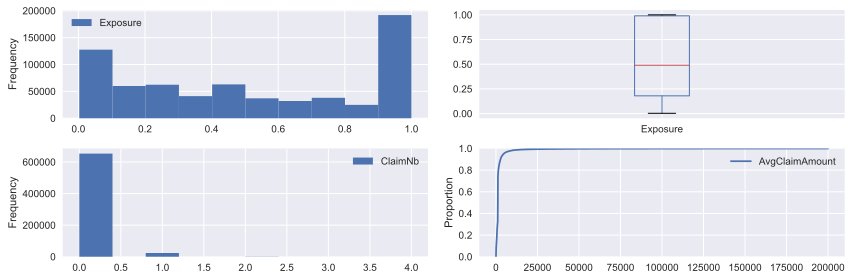

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(12, 4))
df[["Exposure"]].plot.hist(ax=ax[0,0])
df[["Exposure"]].plot.box(ax=ax[0,1])
df[["ClaimNb"]].plot.hist(ax=ax[1,0])
sns.ecdfplot(df[["AvgClaimAmount"]].query("AvgClaimAmount > 0"))
fig.tight_layout();

# largest amount of policies are at the beginning and at the end
# boxplot represents the same dat
# bottom left: the vast majority of the insurance policy holders didnt make any claim
# bottom right: most clams are small, but there are some outliers of claims with a value of 2000000

### Split data

- We will split the dataset into a training and a testing subset
- This will allow us to see test the out of sample performance of our model

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=50000)

# copy dataframe to avoid warnings later
df_train = df_train.copy()
df_test = df_test.copy()  

print(f"Training dataset has {df_train.shape[0]} rows and testing has {df_test.shape[0]}")


# split in training and test subsets= instruct the model that has desirable chararcteristics for prrediction (=accurattely predict some new datta that was not trained on) 
# you want to be able to be able to use a subset of the data that i've alreadh collecteed to evaluate the predictive characteristics of the triain model
# and see how well it does
# use the training to build the parameters of the model (training: majoriity of the data) 

Training dataset has 628013 rows and testing has 50000


### Objective

- Our objective with this dataset will be to play role of insurer and model the PurePremium amount based on driver characteristics
- We have two approaches:
    1. Model the expected number of claims (Poisson) and averge claim amount (Gamma), then multiply the two estimates together
    2. Model total claim amount directly using a Tweedie regression

## Poisson

- The Poisson distribution is a discrete distribution characterizing the number of occurances of an event ($y$) in a fixed amount of time, given the average or expected number of events ($\mu$)
- The distribution has one parameter $\mu$ and has pmf: $$f(y;\mu) = \frac{\mu^y e^{-\mu}}{y!} = \exp(y \log \mu - \mu - \log y!)$$

- This has the form of our exponential family distribution with
$$\begin{aligned}
\phi &= 1 \\
\beta &= \log \mu\\
b(\beta) &= \exp(\beta) = \mu \\
c(y, \phi) &= - \log y!
\end{aligned}$$
- Because $E[y] = \mu > 0$, we must have a link function that maps from $(-\infty, \infty) \rightarrow (0, \infty)$
- A natural choice for the link function is the log function $g(\mu) = \log(\mu)$, which implies $E[y_i|x_i] =\mu_i = \exp(x_i^T \theta)$

### Poisson PMF

- Let's take a look at the pmf for the Poisson distribution

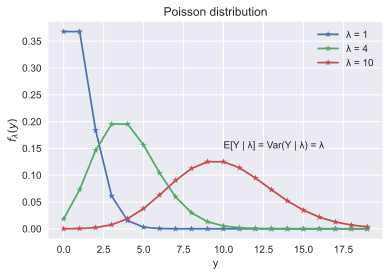

In [7]:
def plot_pmf(dist, lb=0, ub=20, ax=None, **kw):
    if ax is None:
        _, ax = plt.subplots()
    x = np.arange(lb, ub)
    ax.plot(x, dist.pmf(x), "*-")
    return ax
    
fig, ax = plt.subplots()
λs = [1, 4, 10]
for λ in λs:
    plot_pmf(st.poisson(λ), ax=ax)
ax.legend([f"λ = {λ}" for λ in λs], loc="upper right") 
ax.set_xlabel("y")
ax.set_ylabel(r"$f_{\lambda}(y)$")
ax.set_title("Poisson distribution")
ax.text(10, 0.15, "E[Y | λ] = Var(Y | λ) = λ");

### Poisson Claims

- The GLM where the expected response is Poisson distributed is known as Poisson regression
- To apply Poisson regression to our claims data, our response variable will be the frequency of claims
- The model we will use is $$
\begin{aligned} 
E[y_i | x_i] &= \mu_i = \exp(x_i^T \theta) \text{, with} \\ 
x_i &= \begin{bmatrix}1 \\ \text{VehPower}_i \\ \text{VehAge}_i \\ \text{DrivAge}_i \\ \text{BonusMalus}_i \\ \log(\text{Density})_i \end{bmatrix}
\end{aligned}$$

- We will also weight each observation by its `Exposure` to encourage the model to pay attention to high exposure policies

In [8]:
for _df in [df_train, df_test]:
    _df["log_Density"] = np.log(_df["Density"])

### Fitting frequency model

- We can use either statsmodels or sklearn to fit our Poisson regression
- We'll start with statsmodels

In [9]:
freq_mod = smf.glm(
    "Frequency ~ VehPower + VehAge + DrivAge + BonusMalus + log_Density", 
    data=df_train, 
    family=sm.families.Poisson(),
    var_weights=df_train["Exposure"]
)
freq_fit = freq_mod.fit()
freq_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:               628013
Model:                            GLM   Df Residuals:                   628007
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94507.
Date:                Thu, 10 Feb 2022   Deviance:                   1.5300e+05
Time:                        22:09:10   Pearson chi2:                 1.04e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.9187      0.048   -103.284      0.000      -5.012      -4.825
VehPower        0.0313      0.003     10.018      0.000       0.025       0.037
VehAge         -0.0108      0.001     -9.152      0.000      -0.013      -0.009
DrivAge         0.0043      0.000      9.153      0.000       0.003       0.005
BonusMalus      0.0258      0.000     74.421      0.000       0.025       0.026
log_Density     0.0695      0.003     20.044      0.000       0.063       0.076
===============================================================================
"""

### Visualizing results

- To help us make sense of these results, we will use a function from the sklearn tutorial above

In [10]:
def plot_obs_pred(df, feature, weight, observed, predicted, y_label=None,
                  title=None, ax=None, fill_legend=False):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )

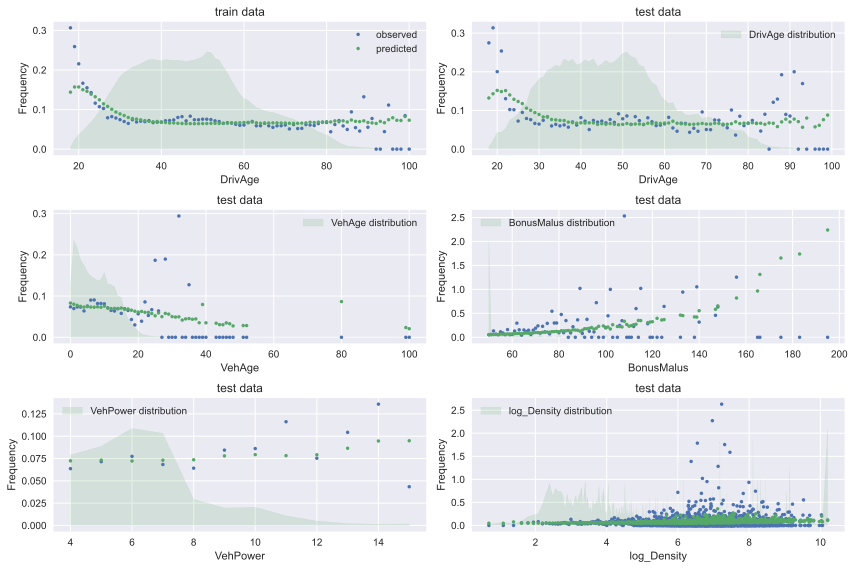

In [11]:
def plot_model_outcomes(fit, df_train, df_test, observed, weight="Exposure"):
    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 8))

    plot_obs_pred(
        df=df_train,
        feature="DrivAge",
        weight=weight,
        observed=observed,
        predicted=fit.predict(df_train),
        y_label=observed,
        title="train data",
        ax=ax[0, 0],
    )

    plot_obs_pred(
        df=df_test,
        feature="DrivAge",
        weight=weight,
        observed=observed,
        predicted=fit.predict(df_test),
        y_label=observed,
        title="test data",
        ax=ax[0, 1],
        fill_legend=True
    )

    plot_obs_pred(
        df=df_test,
        feature="VehAge",
        weight=weight,
        observed=observed,
        predicted=fit.predict(df_test),
        y_label=observed,
        title="test data",
        ax=ax[1, 0],
        fill_legend=True
    )

    plot_obs_pred(
        df=df_test,
        feature="BonusMalus",
        weight=weight,
        observed=observed,
        predicted=fit.predict(df_test),
        y_label=observed,
        title="test data",
        ax=ax[1, 1],
        fill_legend=True
    )

    plot_obs_pred(
        df=df_test,
        feature="VehPower",
        weight=weight,
        observed=observed,
        predicted=fit.predict(df_test),
        y_label=observed,
        title="test data",
        ax=ax[2, 0],
        fill_legend=True
    )

    plot_obs_pred(
        df=df_test,
        feature="log_Density",
        weight=weight,
        observed=observed,
        predicted=fit.predict(df_test),
        y_label=observed,
        title="test data",
        ax=ax[2, 1],
        fill_legend=True
    )
    fig.tight_layout();
    return fig
    

plot_model_outcomes(freq_fit, df_train, df_test, observed="Frequency", weight="Exposure");

Comments:

- Claim frequency is very high for drivers younger than 25 and older than 80
- As BonusMalus rises, so do claims
- The relationshp between log(Density) and claim frequency is positive, but our model doesn't capture much of the variation

## Gamma

- The Gamma distribution is a continuous distribution with support in $\mathbb{R}^{+}$
- The distribution has two parameters: $\mu, \nu \in \mathbb{R}^{+}$ and has pdf: $$f_{\Gamma}(y; \mu, \nu) = \frac{1}{\Gamma(\nu)} \left(\frac{\mu}{\mu}\right)^{\nu}y^{\nu-1} e^{-\frac{\nu}{\mu} y}$$
- With some heroic algebraic manipulation, $f_{\Gamma}$ can be put into the form of $f_{EDM}$ (trust us 😉)
- Because the suppport of the Gamma distribution is $\mathbb{R}^{+}$, we need a link function that can map from $(-\infty, \infty)$ to $(0, \infty)$
- The most common link function is again the log link, which implies $E[y_i|x_i] =\mu_i = \exp(x_i^T \theta)$

### Visualizing $f_{\Gamma}$

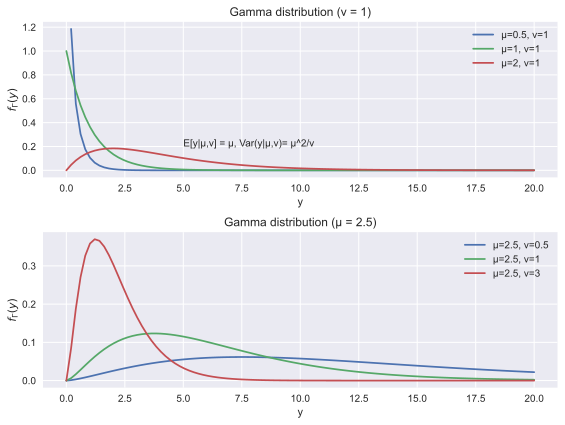

In [12]:
def plot_pdf(dist, lb=0, ub=20, ax=None, **kw):
    if ax is None:
        _, ax = plt.subplots()
    x = np.linspace(lb, ub, 100)
    ax.plot(x, dist.pdf(x), **kw)
    return ax
    
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,6))
μνs = [(0.5, 1), (1, 1), (2,1), (2.5, 0.5), (2.5, 1), (2.5,3)]
for μ in [0.5, 1, 2]:
    ν = 1  # fixed
    label = f"μ={μ}, ν={ν}"
    plot_pdf(st.gamma(μ, scale=μ/ν), ax=ax[0], label=label)
    
for ν in [0.5, 1, 3]:
    μ = 2.5  # fixed
    label = f"μ={μ}, ν={ν}"
    plot_pdf(st.gamma(μ, scale=μ/ν), ax=ax[1], label=label)

for _ax in ax:
    
    _ax.legend(loc="upper right")
    _ax.set_xlabel("y")
    _ax.set_ylabel(r"$f_{\Gamma}(y)$")

ax[0].set_title("Gamma distribution (ν = 1)")
ax[1].set_title("Gamma distribution (μ = 2.5)")
ax[0].text(5, 0.2, "E[y|μ,ν] = μ, Var(y|μ,ν)= μ^2/ν")
fig.tight_layout();

Comments

- The parameter $\mu$ dictates shape: notice $\mu \le 1$ vs $\mu > 1$
- $\mu$ has stronger impact on spread of distribution ($\text{Var} = \mu^2/\nu$)

### Gamma regression

- The GLM where the expected response is Gamma distributed is called Gamma regression
- As noted above, the expected value of the model prediction is $E[y_i | x_i] = \mu_i = \exp(x_i^T \theta)$
- The variance of the prediciton is $\text{Var}(y_i | x_i) = \mu_i^2 / \nu$
- Note that the variance now changes with the mean
- This means that Gamma regression is appropriate when the variation in the prediction should increase with the mean value of the prediction

### Gamma claims

- We will use Gamma regression to model the average claim amount
- The implication of the variance depending on the mean makes sense in this setting
    - Suppose $y_i$ = \$100$. This would come from minor accident. Variance of claim amount for minor damage is small
    
    - Alternatively, suppose $y_i = \$10,000$. This would be a larger accident. Large accidents likely have higher variance/dispersion
- We will use the same set of regressors as with the Poisson model


In [13]:
# note: support of gamma is (0, ∞), not [0, ∞)
# we need to filter out zero claims
df_train_pos = df_train.query("ClaimAmount > 0")
df_test_pos = df_test.query("ClaimAmount > 0")

sev_mod = smf.glm(
    "AvgClaimAmount ~ VehPower + VehAge + DrivAge + BonusMalus + log_Density", 
    data=df_train_pos,
    family=sm.families.Gamma(link=sm.families.links.log()), 
    var_weights=df_train_pos["ClaimNb"]
)
sev_fit = sev_mod.fit()
sev_fit.summary()


# gamma family
# look ar coefficients

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         AvgClaimAmount   No. Observations:                23108
Model:                            GLM   Df Residuals:                    23102
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                          15.093
Method:                          IRLS   Log-Likelihood:            -2.2644e+05
Date:                Thu, 10 Feb 2022   Deviance:                       34933.
Time:                        22:09:19   Pearson chi2:                 3.49e+05
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.1951      0.194     37.065      0.000       6.815       7.576
VehPower        0.0167      0.012      1.352      0.176      -0.008       0.041
VehAge         -0.0032      0.005     -0.656      0.512      -0.013       0.006
DrivAge         0.0014      0.002      0.736      0.462      -0.002       0.005
BonusMalus      0.0048      0.001      3.420      0.001       0.002       0.008
log_Density    -0.0116      0.014     -0.858      0.391      -0.038       0.015
===============================================================================
"""

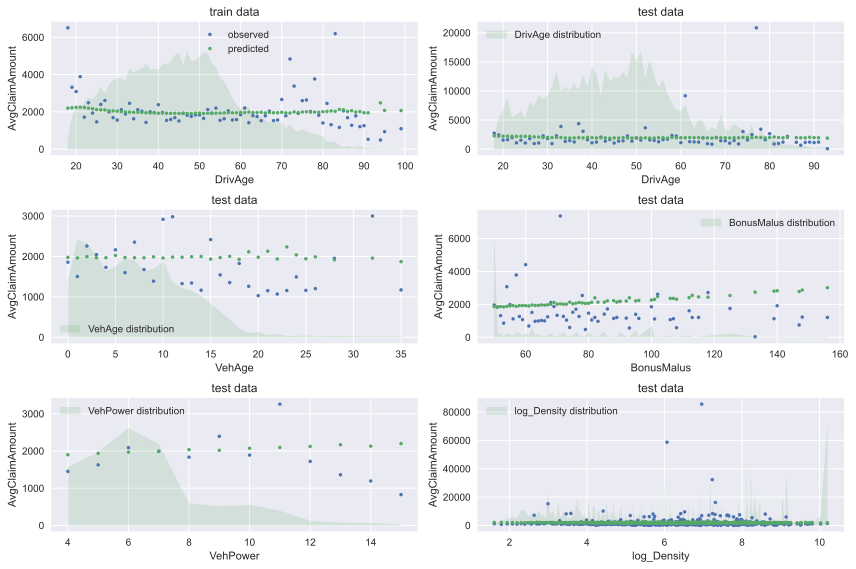

In [14]:
plot_model_outcomes(sev_fit, df_train_pos, df_test_pos, observed="AvgClaimAmount", weight="ClaimNb");

## Combining Poisson + Gamma

- We now have models for :
    - `Frequency ~  Poisson` (Frequency = ClaimNb/Exposure)
    - `AvgClaimAmount ~  Gamma` (AvgClaimAmount = ClaimAmount/ClaimNb)
- Our goal is to predict `PurePremium = ClaimAmount/Exposure`
- We can multiply the prediction from the two models to approximate the PurePremium 

In [15]:
class FreqAvgProduct:
    def __init__(self, freq_fit, sev_fit):
        self.freq_fit = freq_fit
        self.sev_fit = sev_fit
    
    def predict(self, X):
        return self.freq_fit.predict(X) * self.sev_fit.predict(X)

In [16]:
product_fit = FreqAvgProduct(freq_fit, sev_fit)

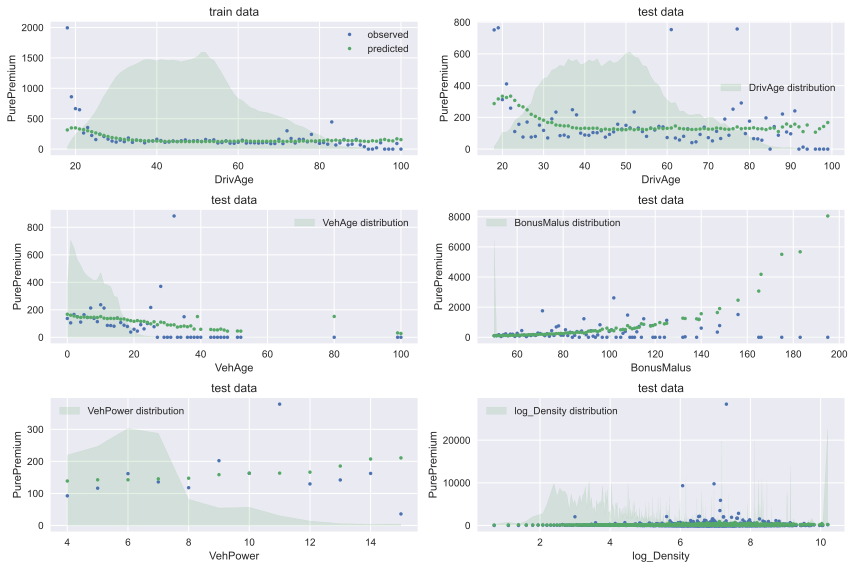

In [17]:
plot_model_outcomes(product_fit, df_train, df_test, observed="PurePremium", weight="Exposure");

## Tweedie

- The final GLM we will consider today is called the Tweedie GLM
- We won't cover the details of the Tweedie distribution here
- Instead, we'll note that when the Tweedie parameter $p$ is between 1 and 2, the Tweedie GLM acts like the compound Poisson Gamma model we just computed (compound model is special case of Tweedie GLM)
- We'll use a value of $p = 1.9$ and have statsmodels fit a Tweedie GLM to target the `PurePremium` directly

In [18]:
pure_mod = smf.glm(
    "PurePremium ~ VehPower + VehAge + DrivAge + BonusMalus + log_Density", 
    data=df_train,
    family=sm.families.Tweedie(link=sm.families.links.log(), var_power=1.9), 
    var_weights=df_train["Exposure"]
)
pure_fit = pure_mod.fit()
pure_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            PurePremium   No. Observations:               628013
Model:                            GLM   Df Residuals:                   628007
Model Family:                 Tweedie   Df Model:                            5
Link Function:                    log   Scale:                          1044.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 10 Feb 2022   Deviance:                   1.1249e+07
Time:                        22:09:51   Pearson chi2:                 6.56e+08
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.7909      0.364      4.915      0.000       1.077       2.505
VehPower        0.0481      0.022      2.179      0.029       0.005       0.091
VehAge         -0.0254      0.008     -3.187      0.001      -0.041      -0.010
DrivAge         0.0097      0.003      2.872      0.004       0.003       0.016
BonusMalus      0.0355      0.003     10.665      0.000       0.029       0.042
log_Density     0.0714      0.024      2.978      0.003       0.024       0.118
===============================================================================
"""

In [19]:
plot_model_outcomes(pure_fit, df_train, df_test, observed="PurePremium", weight="Exposure");

### Ordered Lorenz Curve

- We'll wrap up our analysis by comparing the two models for `PurePremium` against an oracle that can see the future
- We'll construct a plot of cumulative claims where...
    - Policy holders are ranked from safest to riskiest (order by `PurePremium`) and laid out on x-axis
    - Fraction of observed total claims plotted on y-axis
- This follows the sklearn tutorial and is best understood by seeing it, so let's dive in!

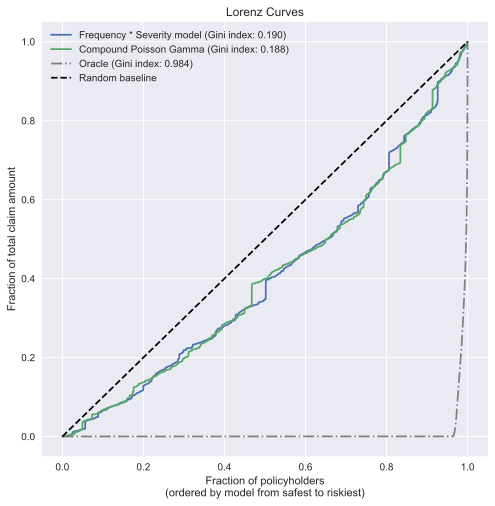

In [ ]:
from sklearn.metrics import auc

def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_product = freq_fit.predict(df_test) * sev_fit.predict(df_test)
y_pred_total = pure_fit.predict(df_test)

for label, y_pred in [("Frequency * Severity model", y_pred_product),
                      ("Compound Poisson Gamma", y_pred_total)]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"])
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"])
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray",
        label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black",
        label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel=('Fraction of policyholders\n'
            '(ordered by model from safest to riskiest)'),
    ylabel='Fraction of total claim amount'
)
ax.legend(loc="upper left")

## Summary

- The generalized linear model extends the linear regression framework to settings beyond the case of normally distributed responses with constant variance
- The GLM is composed of
    1. A linear prediction $\eta_i =x_i^T \theta$
    2. A family $y_i | x_i \sim f$
    3. A link function $g(\mu_i) = \eta_i$
- The table below summarizes the subtypes of GLM we have learned about:

| Response type | Family | Link |
| ------------- | ------ | ---- |
| continuous | gaussian | identity |
| binary | binomial/bernoulli | logit |
| count | poisson | log |
| average severity | gamma | log |
| total severity | tweedie | log |